In [1]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps


from astropy.io import fits
from IPython.display import HTML
from hcipy import *

from iefc_utils import *

# import iefc_utils

import sys
import os

sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')
plt.style.use('spieposter')

PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/scc-sims/Data'



In [2]:
# Set units

pupil_diameter = 6.5
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution


pupil_grid = make_pupil_grid(256, diameter=1.2*pupil_diameter)    # Pad the grid to offer a bit more room

uniform_grid = make_uniform_grid([256, 256, 100], extent=[1.2*pupil_diameter, 1.2*pupil_diameter, 10]).shifted([0, 0, 10])


focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)

prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

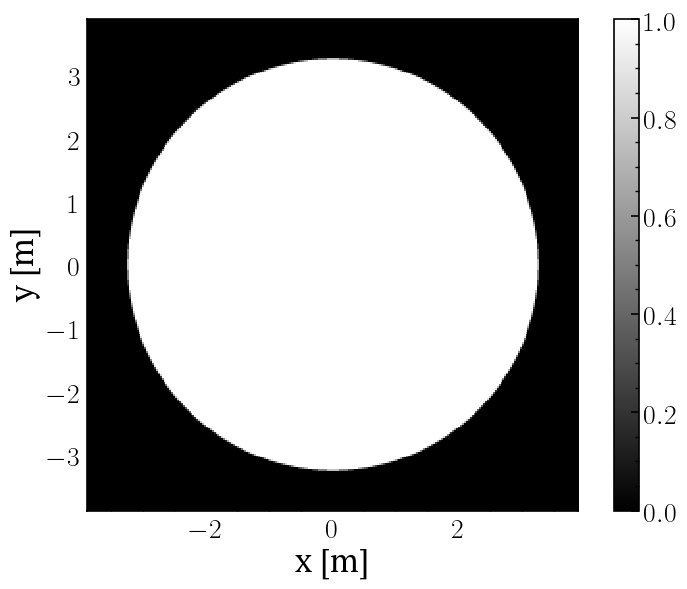

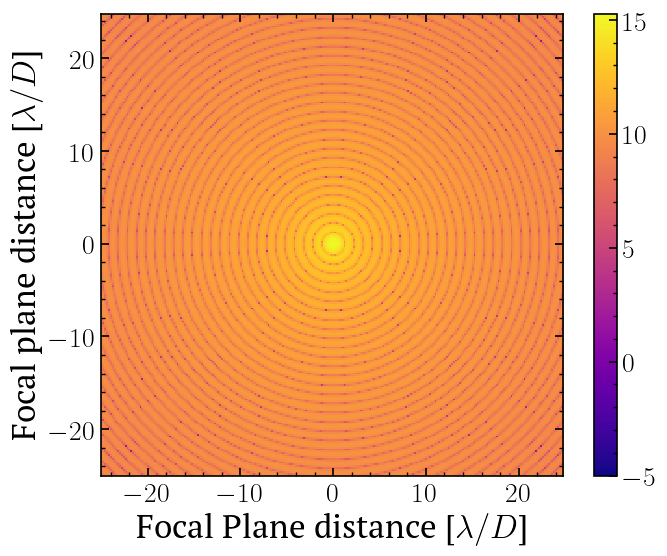

In [3]:
telescope_pupil_circ = evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

wavefront.total_power = 1

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

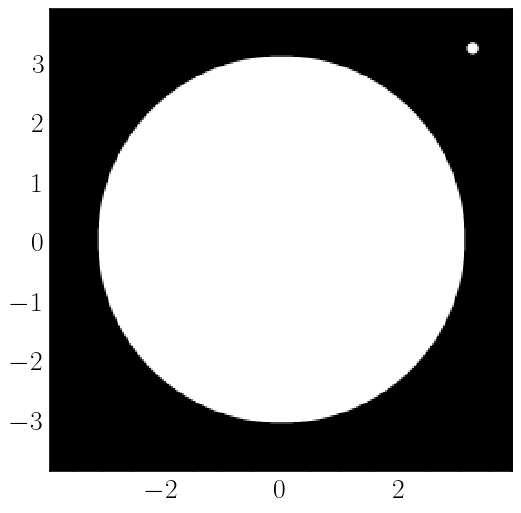

In [4]:
# Generate slightly undersized Lyot Stop                   
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4)


# Add pinhole to Lyot mask 
# pinhole_pos = 0.8 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])
pinhole_pos = 0.7 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])

pinhole = evaluate_supersampled(make_circular_aperture(0.03*pupil_diameter, center=pinhole_pos), pupil_grid, 4)

scc_mask = lyot_mask + pinhole

# Plot SCC mask
imshow_field(scc_mask, cmap='gray')
plt.show()

scc_stop = Apodizer(scc_mask)

lyot_stop = Apodizer(lyot_mask)

pinhole_stop = Apodizer(pinhole)

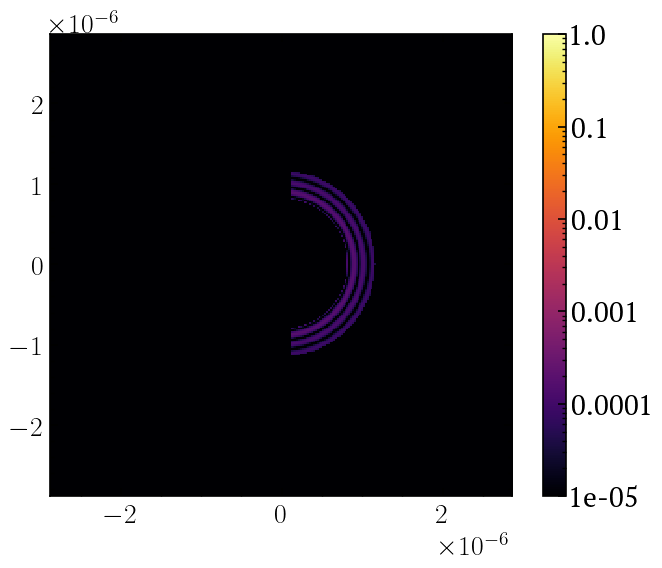

In [5]:


# Define control region

Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid


# fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
# fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
# focal_mask *= focal_grid.x > 1*sr

wavefront_circ = Wavefront(telescope_pupil_circ, wavelength)

wavefront_circ.total_power = 1

 # fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   #  Overlay modes from 6-14 lambda/d

fourier_mask = (fourier_grid.as_('polar').r < 11) * (fourier_grid.as_('polar').r > 6)   
fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 

focal_mask = (focal_grid.as_('polar').r < 10*sr) * (focal_grid.as_('polar').r > 7*sr) 

focal_mask *= focal_grid.x > 1*sr

focal_image_circ = prop.forward(wavefront_circ)

dark_hole_pixels_circ = focal_image_circ.power*focal_mask

imshow_psf(dark_hole_pixels_circ/focal_image_circ.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

In [6]:
############ Initialize VVC
charge = 4                      # Generate a charge 4 scalar CG
coro_vortex = VortexCoronagraph(pupil_grid, charge=charge)

In [7]:
alpha = 4
beta = 2
u0 = 0.1 # outer scale of turbulence
f0 = 0.5 # outer scale of temporal variations

ptv = 0.1*wavelength
PSD = time_varying_aberrations(0.1*wavelength, 4, 2, 0.1, 0.5)
psd_wf = PSD(uniform_grid)

In [8]:
sa_screen = psd_2_screen(PSD, aperture=telescope_pupil_circ, ptv=ptv)

In [9]:
sa_opt, sa_field = sa_screen(pupil_grid, uniform_grid)

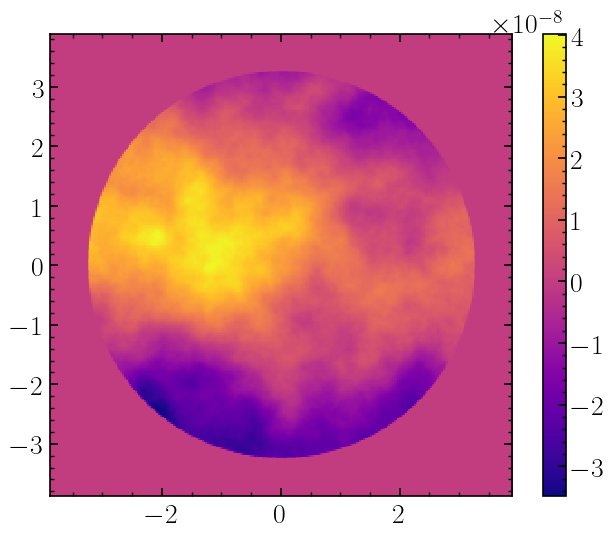

In [10]:
imshow_field(sa_field[3], pupil_grid)
plt.colorbar()

In [11]:
response_matrices_selected = np.load('./jacobian_scc_circ_ap_7_10_new.npy')

reconstruction_matrices_selected = np.load('./rec_mat_scc_circ_ap_7_10_new.npy')

In [12]:
reconstruction_matrices_selected.shape

(272, 1854)

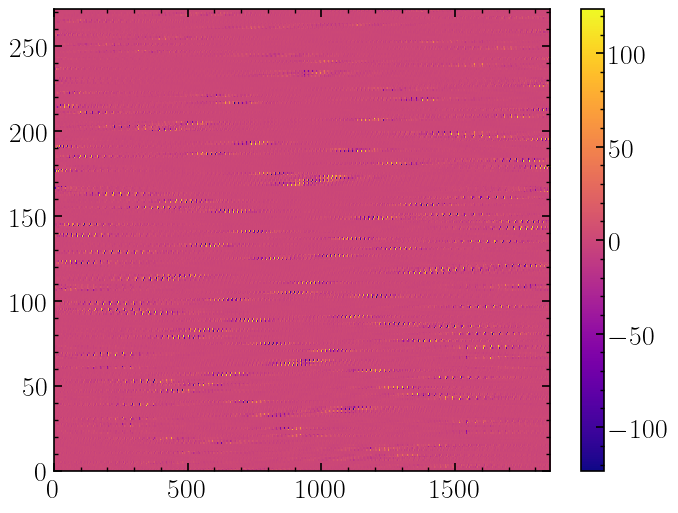

In [13]:
plt.imshow(response_matrices_selected,aspect='auto')
plt.colorbar()
plt.show()

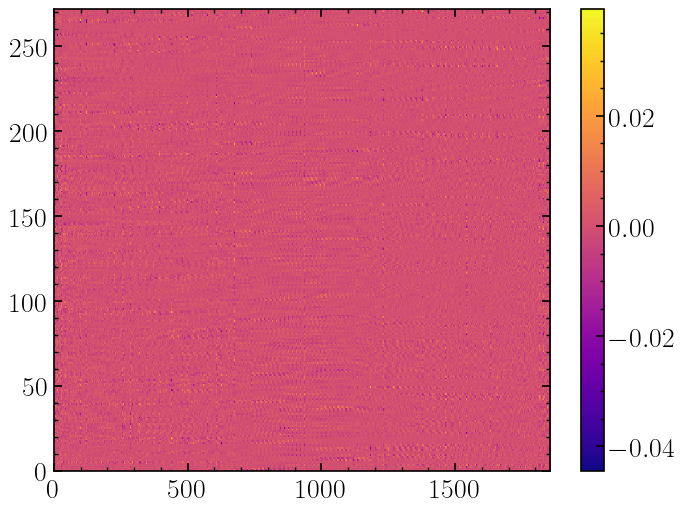

In [14]:
plt.imshow(reconstruction_matrices_selected,aspect='auto')
plt.colorbar()
plt.show()

In [15]:
def run_iefc(num_iterations=20, efc_gain=0.5, aberrations=0.1, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=None, rec_mat_selected=reconstruction_matrices_selected, save_data=False):

    fourier_dm_selected.flatten()

    wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF

    wf.total_power = 1

    optical_system_scc = OpticalSystem([scc_stop, prop])
    optical_system_lyot = OpticalSystem([lyot_stop, prop])
    optical_system_pinhole = OpticalSystem([pinhole_stop, prop])

    norm = prop(wf).power.max()

    scc_sensor = make_scc_sensor(optical_system_scc, optical_system_lyot, optical_system_pinhole)

    if sa_optic is None:
        zmodes = make_zernike_basis(3, Dtel, pupil_grid)
        sa_optic = SurfaceAberration(pupil_grid, aberrations * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil_circ, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration

    actuator_cmds = np.zeros(fourier_dm_selected.num_actuators)

    current_cmds = []
    image_cube = []
    mean_ni = []

    image_cube.append(optical_system_scc(coro_vortex(fourier_dm_selected(sa_optic[0](wf)))).power / norm)

    for i in range(num_iterations):
        wf_output = coro_vortex(fourier_dm_selected(sa_optic[i](wf)))


        # print(wf_output)
        psf_scc, psf_lyot, psf_pinhole = scc_sensor(wf_output)  # Perform WFSing w/ SCC

        wf_measurement = extract_measurement_from_scc_image(psf_scc, psf_lyot, psf_pinhole, dark_hole_pixels>0) # Extract diff images

        ef_error = rec_mat_selected.dot(wf_measurement) # Transform WF sensing measurement into DM pattern that gives us error
        actuator_cmds -= efc_gain*ef_error # Apply opposite phase to DM so as to cancel E-field

        fourier_dm_selected.actuators = actuator_cmds
        
        print(actuator_cmds) # Check that actuator cmds are ~1e-9

        image_cube.append(optical_system_scc(coro_vortex(fourier_dm_selected(sa_optic[i](wf)))).power / norm)

    mean_ni = [np.mean(image[dark_hole_pixels>0]) for image in image_cube]

    image_cube_field = Field(image_cube, focal_grid)  
   
    if save_data:
       # Uncomment if saving the individual images
        write_field(image_cube_field, f'{PLOT_DIR}/scc_{alpha}_{beta}_{u0}_{f0}_ptv_{np.round(ptv, 3)}.fits')

    return image_cube_field, mean_ni  # TT.actuators


In [ ]:
n_itrs = 100
img_cube, mean_ni = run_iefc(num_iterations=n_itrs, efc_gain=0.4, aberrations=0.1, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=sa_opt, rec_mat_selected=reconstruction_matrices_selected, save_data=True)

[-9.20742280e-10  5.00220203e-10  5.86511447e-10 -4.61679822e-10
  2.64017978e-10  2.20851905e-10 -5.96130267e-10 -5.44495885e-10
  1.45941347e-10  1.15107719e-10 -2.80343497e-10  4.30988210e-10
  5.46154504e-10  3.07713320e-10 -2.35363870e-10  3.88088297e-10
  4.07624452e-10 -2.40894696e-10 -2.22874024e-10  1.36546626e-11
 -7.44361071e-11  4.83182458e-11  1.11791254e-10  7.32237155e-11
  3.34264957e-11 -7.01555413e-11  1.81086246e-11 -2.55114789e-10
  7.62151101e-11 -2.00345877e-10 -8.37414336e-11  2.16831742e-10
 -2.78289894e-10 -1.29459755e-10  3.34010753e-11 -9.57027138e-11
  5.01051433e-10  4.29181344e-10 -4.82337235e-11 -2.71886383e-10
  9.59524645e-10 -2.11240411e-10 -1.09233916e-10  4.17385488e-10
  1.65748345e-10 -7.86864905e-11  2.28211064e-10 -3.22928504e-10
 -3.66084080e-10 -1.36453653e-10  1.10179626e-10  8.07724735e-13
  1.06711700e-11  2.42434014e-10  4.81255601e-11 -3.40292326e-10
 -5.51059160e-10  3.80298035e-10 -4.32228559e-10 -2.05898088e-10
 -4.09423232e-12  2.56514

In [17]:
mean_ni = np.array(mean_ni) 

In [18]:
mean_ni

array([3.40769201e-06, 1.68314643e-06, 8.87219851e-07, 5.02526223e-07,
       3.08969278e-07, 2.07580171e-07, 1.54000378e-07, 1.24932459e-07,
       1.08879973e-07, 9.99648586e-08, 9.50682192e-08, 9.24659120e-08,
       9.11685769e-08, 9.05929027e-08, 9.03950835e-08, 9.03773357e-08,
       9.04265896e-08, 9.03672846e-08, 9.02305604e-08, 9.00419596e-08,
       8.97975340e-08, 8.95020966e-08, 8.91626249e-08, 8.87839855e-08,
       8.83675848e-08, 8.79143270e-08, 8.74262146e-08, 8.69079651e-08,
       8.63574133e-08, 8.57692080e-08, 8.51378699e-08, 8.44595828e-08,
       8.37303747e-08, 8.29484114e-08, 8.21128503e-08, 8.12280316e-08,
       8.03042749e-08, 7.93500536e-08, 7.83755605e-08, 7.73903176e-08,
       7.64015325e-08, 7.54178248e-08, 7.44501729e-08, 7.35092224e-08,
       7.26000824e-08, 7.17255136e-08, 7.08891995e-08, 7.00961774e-08,
       6.93516584e-08, 6.86559355e-08, 6.80103638e-08, 6.74136792e-08,
       6.68746375e-08, 6.63895403e-08, 6.59606355e-08, 6.55843644e-08,
      

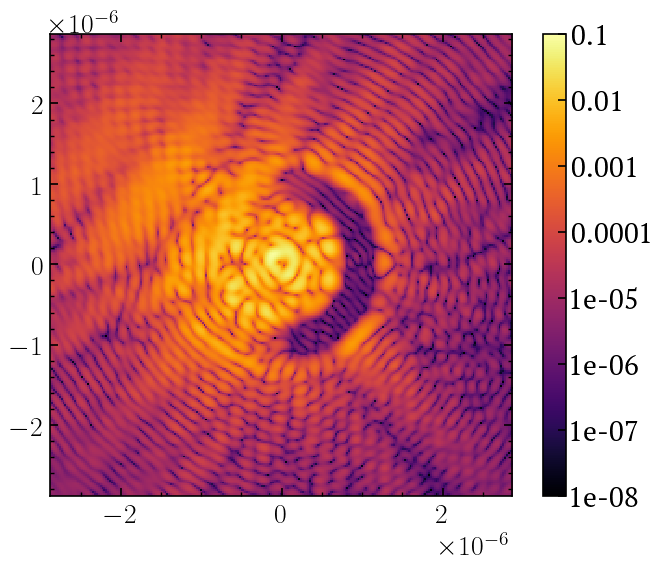

In [19]:
imshow_psf(img_cube[-1] / norm )

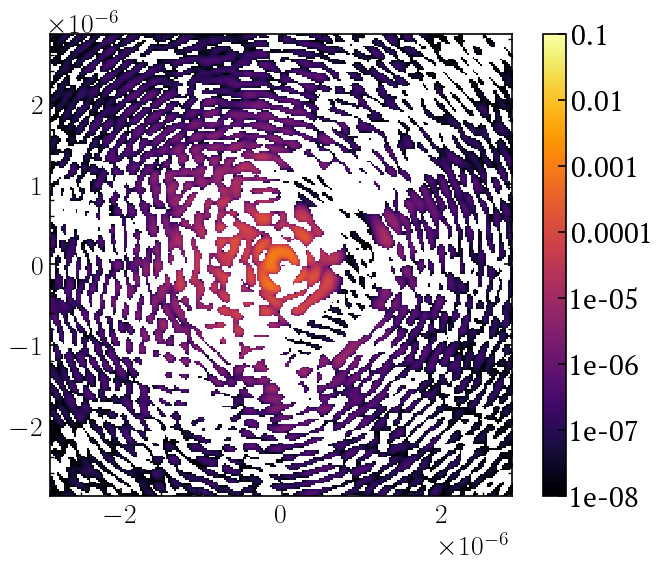

In [107]:
imshow_psf((img_cube[27] - img_cube[26]) / norm )